# Обучение нейросетевых моделей

В этом файле мы обучаем модели глубокого обучения для 2-х NER (Named Entity Recognition) задач:

 - Разбивку имени на составляющие (Фамилия, имя, отчество) - используем в качестве основы модель Bert-base
 - Разбивку адреса на составляющие (регион, район, город, ...) - используем в качестве основы модель rubert-base-cased

Обе модели тонко настраиваются на специаально сгенерированных наборах данных. Генераторы наборов данных описаны в jupyter-ноутбуке Data Parser.

А также загружаем модель M2M100 для исправления ошибок. Так как полноценное обучение и даже тонкая настройка данной модели представляет некоторую сложность, было принято решение провести квантизацию данной модели.

## Модули

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import time
from tqdm.auto import tqdm

import datetime
import os
import re

from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer, AutoModelForTokenClassification, AutoTokenizer, \
    pipeline, DataCollatorForTokenClassification, get_scheduler

from accelerate import Accelerator

import torch
from torch.optim import AdamW
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader

import evaluate

In [2]:
np.random.seed(42)

## Исправление орфографии

### Квантизация модели

Так как базовая модель занимает достаточно много места (около 4.3 ГБ), мы можем провести квантизацию модели, чтобы уменьшить её размер на диске.  

В целом, квантизация модели не должна приводить к значимой потери качества её предсказаний.

In [3]:
# path_to_model = "ai-forever/RuM2M100-1.2B" 

path_to_model = "model/M2M100ForConditionalGeneration/" 
path_to_tokenizer = "model/M2M100Tokenizer/"

In [4]:
model_M100_spell = M2M100ForConditionalGeneration.from_pretrained(path_to_model)
tokenizer_M100_spell = M2M100Tokenizer.from_pretrained(path_to_tokenizer)

In [5]:
# model_M100_spell.save_pretrained("model/M2M100ForConditionalGeneration/")
# tokenizer_M100_spell.save_pretrained("model/M2M100Tokenizer/")

In [6]:
def calc_size(model):

    '''
    Calculates size of the model
    '''
    
    torch.save(model.state_dict(), "./tmp/model.p")
    size=os.path.getsize("./tmp/model.p")
    os.remove('./tmp/model.p')
    return "{:.3f} KB".format(size / 1024)

In [7]:
calc_size(model_M100_spell)

'4386893.908 KB'

In [8]:
quantized_model = torch.quantization.quantize_dynamic(model_M100_spell, {torch.nn.Linear}, dtype=torch.qint8)

In [9]:
calc_size(quantized_model)

'1157517.419 KB'

Модель достаточно сильно сжалась - примерно в 4 раза!

In [10]:
torch.save(quantized_model, "model/M2M100_spellchecker/quantized_model.pt")
tokenizer_M100_spell.save_pretrained("model/M2M100_tokenizer/")

('model/M2M100_tokenizer/tokenizer_config.json',
 'model/M2M100_tokenizer/special_tokens_map.json',
 'model\\M2M100_tokenizer\\vocab.json',
 'model\\M2M100_tokenizer\\sentencepiece.bpe.model',
 'model/M2M100_tokenizer/added_tokens.json')

### Тест

Проверим, что квантизованная модель приемлемо работает на наборе данных из формы и нескольких произвольных примерах.

In [11]:
model_M100_spell = torch.load("model/M2M100_spellchecker/quantized_model.pt")
model_M100_spell.eval()

c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:314: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(14341, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(14341, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-23): 24 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): DynamicQuantizedLinear(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (v_proj): DynamicQuantizedLinear(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (q_proj): DynamicQuantizedLinear(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (out_proj): DynamicQuantizedLinear(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affi

In [12]:
path_to_tokenizer = "model/M2M100_tokenizer/"
tokenizer_M100_spell = M2M100Tokenizer.from_pretrained(path_to_tokenizer)

In [13]:
def correct_errors(sentence_in: str) -> str:

    """
    Функция для исправления орфографии в модели 

    Параметры:
    sentence_in : str
        Предложение с (возможно) орфографическими ошибками

    Возвращает:
    answer : str
        Предложение, очищенное от ошибок
    """

    encodings = tokenizer_M100_spell(sentence_in, return_tensors="pt")

    generated_tokens = model_M100_spell.generate(**encodings, 
                                                 forced_bos_token_id=tokenizer_M100_spell.get_lang_id("ru"), 
                                                 max_new_tokens = 200)
    
    answer = tokenizer_M100_spell.batch_decode(generated_tokens, skip_special_tokens=True)
    
    answer = re.sub('[a-zA-Z]+', '', answer[0]).strip()

    return answer

In [14]:
sentence = "Основая цель мероприятия 5 орпеля 2020 - практичиская оттработка навыкоф по ока занию помощь гражданов, попавшим в ДТП, а также повышение и совершенствование уровня профессиональной подготовки сотрудников МЧС при проведении аварийно-спасательных работ по ликвидации последствий дорожно-транспортных проишествий, сокращение временной показатель реагирование."

print("Input:", sentence)
print("Output:", correct_errors(sentence_in=sentence))

Input: Основая цель мероприятия 5 орпеля 2020 - практичиская оттработка навыкоф по ока занию помощь гражданов, попавшим в ДТП, а также повышение и совершенствование уровня профессиональной подготовки сотрудников МЧС при проведении аварийно-спасательных работ по ликвидации последствий дорожно-транспортных проишествий, сокращение временной показатель реагирование.


Output: ная цель мероприятия 5 апреля 2020 - практическая отработка навыков по оказанию помощь гражданам, попавшим в ДТП, а также повышение и совершенствование уровня профессиональной подготовки сотрудников МЧС при проведении аварийно-спасательных работ по ликвидации последствий дорожно-транспортных происшествий, сокращение временной показатель реагирование.


In [15]:
sentence = "Фомилию, имя, отчество не изменял"

print("Input:", sentence)
print("Output:", correct_errors(sentence_in=sentence))

Input: Фомилию, имя, отчество не изменял
Output: Фамилию, имя, отчество не изменял


In [16]:
sentence = "Студент, Уфимский фелеал Масковского нифтеного института им. Академика И.М. Губкина"

print("Input:", sentence)
print("Output:", correct_errors(sentence_in=sentence))

Input: Студент, Уфимский фелеал Масковского нифтеного института им. Академика И.М. Губкина
Output: , Уфимский филиал Московского нефтяного института им. Академика И.М. Губкина


In [17]:
sentence = "Имею загррничный паспорт 6543217 89, ОУМС пос. Хор Хабаровского края, 04.02.2012"

print("Input:", sentence)
print("Output:", correct_errors(sentence_in=sentence))

Input: Имею загррничный паспорт 6543217 89, ОУМС пос. Хор Хабаровского края, 04.02.2012
Output: Имею загрничный паспорт 654321789, ОУМС пос. Хор Хабаровского края, 04.02.2012


In [ ]:
sentence = "Калужская обл., г. Обнинск, ул. Гагарина, д. 5, кв.52"

print("Input:", sentence)
print("Output:", correct_errors(sentence_in=sentence))

Наблюдаются некоторые галлюционации у модели, однако в целом качество исправления опечаток приемлемо.

## NER 

### Общий раздел

Несколько общих функций, используемых при обучении NER моделей.   
Примеры и процедура для кода взяты отсюда: https://huggingface.co/learn/nlp-course/chapter7/2

In [3]:
def align_labels_with_tokens(labels, word_ids, label_names):

    new_labels = []
    current_word = None
    
    for word_id in word_ids:
        if word_id != current_word:

            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            # if label % 2 == 1:
            #     if label < len(label_names)-1:
            #         label += 1
            new_labels.append(label)

    return new_labels

In [4]:
def compute_metrics(eval_preds, label_names, metric):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [5]:
def postprocess(predictions, labels, label_names):
    
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

### NER (для имен)

#### Настройки

В качестве основной модели мы используем https://huggingface.co/ai-forever/ruBert-base. Эту модель также использовали при тонкой настройке модели viktoroo/sberbank-rubert-base-collection3, которая заточена на NER задачи. Для нашего проекта мы также будем делать тонкую настройку ruBert модели, но для конкретной задачи - вычленения из имени фамилии, имени и отчества.

Примеры кода и процедура взяты отсюда: https://huggingface.co/learn/nlp-course/chapter7/2

In [6]:
# path_to_model = "viktoroo/sberbank-rubert-base-collection3" 
# path_to_tokenizer = "viktoroo/sberbank-rubert-base-collection3"

# path_to_model = "ai-forever/ruBert-base" 
# path_to_tokenizer = "ai-forever/ruBert-base"

# path_to_model = "ai-forever/ruBert-large" 
# path_to_tokenizer = "ai-forever/ruBert-large"

# path_to_model = "ai-forever/ruRoberta-large" 
# path_to_tokenizer = "ai-forever/ruRoberta-large"

path_to_model = "DeepPavlov/rubert-base-cased" 
path_to_tokenizer = "DeepPavlov/rubert-base-cased"

In [7]:
tokenizer_NER = AutoTokenizer.from_pretrained(path_to_tokenizer, use_fast=True)

В нашем случае достаточно будет создавать только три сущности: имена, фамилии и отчества. Нулевую сущность мы можем опустить, так как в обрабатываемом документе в соответствующих ячейках всегда фигурируют только эти элементы.

In [8]:
label_names = ['PER-NAME', 'PER-SURN', 'PER-PATR']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [9]:
def tokenize_and_align_labels(examples, tokenizer = tokenizer_NER):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids, label_names))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [10]:
model_NER = AutoModelForTokenClassification.from_pretrained(path_to_model,
                                                               id2label=id2label,
                                                               label2id=label2id)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Проверка модели (закомментируем)

In [11]:
# model_NER.save_pretrained("model/model_NER_custom/")
# tokenizer_NER.save_pretrained("model/tokenizer_NER_custom/")

#### Обучение

Подгружаем сгенерированные данные. Алгоритм генерации описан в блокноте "Data parser.ipynb".

In [12]:
names_dataset = pd.read_json("data/names/names_train_large.json")
print(names_dataset.shape)

(40000, 2)


Разделим набор данных на обучающую, валидационную и тестовую выборки.

In [13]:
names_dataset['mode'] = np.random.choice(['train', "val", "test"], size = names_dataset.shape[0], p = [0.7, 0.15, 0.15])

In [14]:
names_dataset['ner_tags'] = names_dataset['ner_tags'].map(lambda x: [i-1 for i in x])
names_dataset.head()

,tokens,ner_tags,mode
0,"[Олимпович, Аввакум, Копылов, Калашников]","[2, 0, 1, 1]",train
1,"[Горюнов, Арсентий, Соболев, Астафьев, Пахомович]","[1, 0, 1, 1, 2]",test
2,"[Фотиевна, Гертруда, Чижова]","[2, 0, 1]",val
3,"[Троицкий, Юзеф, Бенедиктович]","[1, 0, 2]",train
4,"[Людмила, Фадеева, Прохоровна, Грибкова]","[0, 1, 2, 1]",train


In [15]:
trdf = Dataset.from_pandas(names_dataset[names_dataset['mode'] == "train"])
vldf = Dataset.from_pandas(names_dataset[names_dataset['mode'] == "val"])
tedf = Dataset.from_pandas(names_dataset[names_dataset['mode'] == "test"])

dataset_names = DatasetDict({"train": trdf, "validation": vldf, "test": tedf})
dataset_names

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'mode', '__index_level_0__'],
        num_rows: 28122
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'mode', '__index_level_0__'],
        num_rows: 5917
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'mode', '__index_level_0__'],
        num_rows: 5961
    })
})

In [16]:
tokenized_datasets = dataset_names.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset_names["train"].column_names
)

Map:   0%|          | 0/28122 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5917 [00:00<?, ? examples/s]

Map:   0%|          | 0/5961 [00:00<?, ? examples/s]

In [17]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_NER)

In [18]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(4)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    2,    2,    0,    0,    1,    1,    1, -100],
        [-100,    1,    0,    2,    2, -100, -100, -100, -100],
        [-100,    0,    1,    2,    2,    1,    1, -100, -100],
        [-100,    1,    1,    0,    0, -100, -100, -100, -100]])

In [19]:
metric = evaluate.load("seqeval")

In [20]:
model_NER.config.num_labels

3

In [21]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=4,
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"], 
    collate_fn=data_collator, 
    batch_size=8
)

In [22]:
optimizer = AdamW(model_NER.parameters(), lr=5e-05, betas=(0.9,0.999), eps=1e-08)

In [23]:
# accelerator = Accelerator(cpu=True)
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model_NER, optimizer, train_dataloader, eval_dataloader
)

In [24]:
train_dataloader.device

device(type='cuda')

In [25]:
model.device

device(type='cuda', index=0)

In [26]:
num_train_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

cos_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=0.1,
    num_training_steps=num_training_steps,
)

In [27]:
output_dir = "model/test/names/bert-finetuned-ner-" + path_to_model.replace('/', "-")
output_dir

'model/test/names/bert-finetuned-ner-DeepPavlov-rubert-base-cased'

In [28]:
progress_bar = tqdm(range(num_training_steps))
metrics_df = {'epoch': list(range(1, num_train_epochs+1)),
           "precision": [], 
           "recall": [], 
           "f1": [], 
           "accuracy": []}

for epoch in range(num_train_epochs):
    # Training

    model.train()
    
    for i, batch in enumerate(train_dataloader):
        
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        cos_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
        
    model.eval()
    
    for batch in eval_dataloader:

        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered, label_names)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    for key in ["precision", "recall", "f1", "accuracy"]:
        metrics_df[key].append(results[f"overall_{key}"])

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer_NER.save_pretrained(output_dir)

  0%|          | 0/35155 [00:00<?, ?it/s]

c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PER-PATR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PER-NAME seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PER-SURN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


epoch 0: {'precision': 0.9985421981569219, 'recall': 0.9985421981569219, 'f1': 0.9985421981569219, 'accuracy': 0.9995748086638988}
epoch 1: {'precision': 0.9976050398292289, 'recall': 0.9956869673664519, 'f1': 0.9966450807521261, 'accuracy': 0.9986744034815667}
epoch 2: {'precision': 0.999583485187692, 'recall': 0.9995314452311537, 'f1': 0.9995574645320839, 'accuracy': 0.9998249212145466}
epoch 3: {'precision': 0.9998438069453846, 'recall': 0.9998438069453846, 'f1': 0.9998438069453846, 'accuracy': 0.9999499774898705}
epoch 4: {'precision': 0.999791742593846, 'recall': 0.999895860453007, 'f1': 0.999843798812871, 'accuracy': 0.9999499774898705}


#### Тест

In [ ]:
print(path_to_model, end="\n\n")

metrics_df = pd.DataFrame(metrics_df)

print(metrics_df)
metrics_df.iloc[:, 1:].plot();

DeepPavlov/rubert-base-cased
   epoch  precision    recall        f1  accuracy
0      1   0.998542  0.998542  0.998542  0.999575
1      2   0.997605  0.995687  0.996645  0.998674
2      3   0.999583  0.999531  0.999557  0.999825
3      4   0.999844  0.999844  0.999844  0.999950
4      5   0.999792  0.999896  0.999844  0.999950


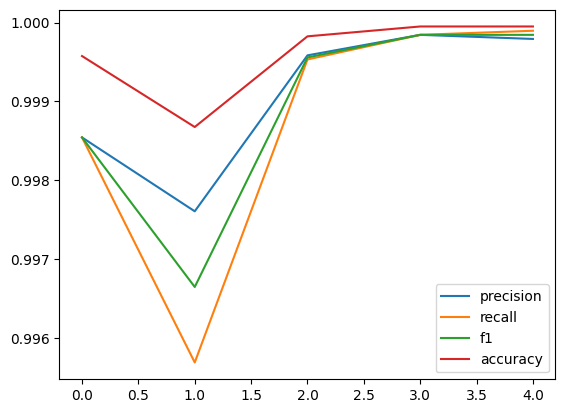

In [29]:
print(path_to_model)

metrics_df = pd.DataFrame(metrics_df)

print(metrics_df)
metrics_df.iloc[:, 1:].plot();

metrics_df.to_csv("metrics_"+path_to_model.replace("/", "-")+".csv")

ai-forever/ruBert-base
   Unnamed: 0  epoch  precision    recall        f1  accuracy
0           0      1   0.997345  0.998072  0.997708  0.999474
1           1      2   0.998959  0.999219  0.999089  0.999710
2           2      3   0.999531  0.999531  0.999531  0.999909
3           3      4   0.999948  0.999896  0.999922  0.999982
4           4      5   0.999948  0.999948  0.999948  0.999964


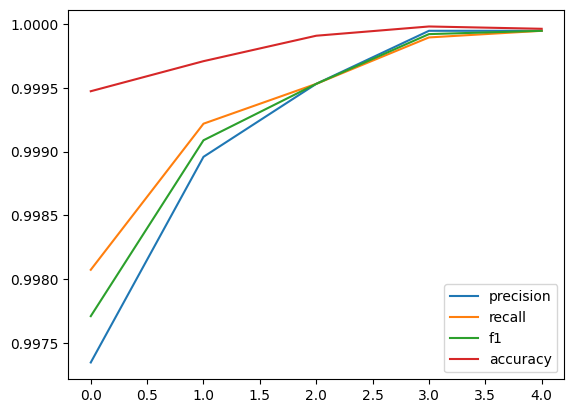

In [6]:
print(path_to_model)

metrics_df = pd.DataFrame(metrics_df)

print(metrics_df)
metrics_df.iloc[:, 1:].plot();

metrics_df.to_csv("metrics_names_"+path_to_model.replace("/", "-")+".csv")

Text(0.5, 1.0, 'Validation metrics for rubert-base model')

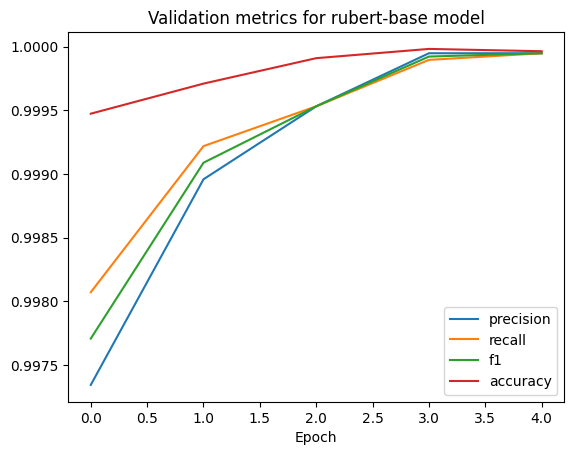

In [84]:
mod = "rubert-base"
metrics_df = pd.read_csv("results/names/metrics_names_ai-forever-" + mod + ".csv")
metrics_df.iloc[:, 3:].plot()
plt.xlabel("Epoch")
plt.title("Validation metrics for " + mod + " model")

Тест лучшей модели

In [30]:
# default
# path_to_model_NER_names = "model/stable/bert-finetuned-ner-names-accelerate" 

# ruBert-base
# path_to_model_NER_names = "model/test/names/bert-finetuned-ner-ai-forever-ruBert-base/" 

# ruBert-large
# path_to_model_NER_names = "model/test/names/bert-finetuned-ner-ai-forever-ruBert-large/" 

# ruRoBerta-large
# path_to_model_NER_names = "model/test/names/bert-finetuned-ner-ai-forever-ruRoberta-large/" 

# deepPavlov cased ruBert-base
path_to_model_NER_names = "model/test/names/bert-finetuned-ner-DeepPavlov-rubert-base-cased/" 

In [31]:
## NER для имен
label_names = ['PER-NAME', 'PER-SURN', 'PER-PATR']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

model_NER = AutoModelForTokenClassification.from_pretrained(path_to_model_NER_names,
                                                               id2label=id2label,
                                                               label2id=label2id)
tokenizer_NER = AutoTokenizer.from_pretrained(path_to_model_NER_names, use_fast=True)

In [32]:
test_dataloader = DataLoader(
    tokenized_datasets["test"], 
    collate_fn=data_collator, 
    batch_size=1
)

In [33]:
accelerator = Accelerator()

model_NER, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
    model_NER, optimizer, train_dataloader, test_dataloader
)

In [34]:
model_NER.cpu()

token_classifier = pipeline(
    "token-classification", model=model_NER, aggregation_strategy="simple", tokenizer=tokenizer_NER
)

In [35]:
test_df = []

for i, batch in enumerate(test_dataloader):

    batch = batch.to("cpu")

    with torch.no_grad():
        outputs = model_NER(**batch)

    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]

    # Necessary to pad predictions and labels for being gathered
    predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
    labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

    predictions_gathered = accelerator.gather(predictions)
    labels_gathered = accelerator.gather(labels)

    # print(predictions_gathered)
    # print(labels_gathered)

    true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered, label_names)

    # print(true_labels)
    # print(true_predictions)

    metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    test_df.append([
            results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        ]),
    
test_df = pd.DataFrame(test_df, columns = ["precision", "recall", "f1", "accuracy"])
print(test_df.mean(axis=0))
test_df.to_csv("test_df_names_"+path_to_model.replace("/", "-")+".csv")

c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PER-SURN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PER-NAME seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PER-PATR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

precision    0.999899
recall       0.999944
f1           0.999916
accuracy     0.999983
dtype: float64


In [60]:
tbl = pd.read_csv("results/names/test_df_names_DeepPavlov-rubert-base-cased.csv")
tbl.mean(axis = 0).round(3)

Unnamed: 0    2980.0
precision        1.0
recall           1.0
f1               1.0
accuracy         1.0
dtype: float64

In [ ]:
print(token_classifier("Макаров Андрей Николаевич"))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity_group': 'SURN', 'score': 0.9999862, 'word': 'мака', 'start': 0, 'end': 4}, {'entity_group': 'PATR', 'score': 0.9999906, 'word': '##ров', 'start': 4, 'end': 7}, {'entity_group': 'NAME', 'score': 0.9999775, 'word': 'андреи', 'start': 8, 'end': 14}, {'entity_group': 'PATR', 'score': 0.99999034, 'word': 'николаевич', 'start': 15, 'end': 25}]


In [ ]:
print(token_classifier("Окрошковская Елена Викторовна"))

print(token_classifier("Кобаева Виола Ролландовна"))

print(token_classifier("Макарова (Пурпурова) Валентина Михайловна"))

[{'entity_group': 'SURN', 'score': 0.9999864, 'word': 'окро', 'start': 0, 'end': 4}, {'entity_group': 'PATR', 'score': 0.9999907, 'word': '##шковская', 'start': 4, 'end': 12}, {'entity_group': 'NAME', 'score': 0.9999781, 'word': 'елена', 'start': 13, 'end': 18}, {'entity_group': 'PATR', 'score': 0.99999046, 'word': 'викторовна', 'start': 19, 'end': 29}]
[{'entity_group': 'SURN', 'score': 0.9999862, 'word': 'коба', 'start': 0, 'end': 4}, {'entity_group': 'PATR', 'score': 0.9999906, 'word': '##ева', 'start': 4, 'end': 7}, {'entity_group': 'NAME', 'score': 0.9999781, 'word': 'виола', 'start': 8, 'end': 13}, {'entity_group': 'PATR', 'score': 0.99999046, 'word': 'ролландовна', 'start': 14, 'end': 25}]
[{'entity_group': 'SURN', 'score': 0.9999865, 'word': 'мака', 'start': 0, 'end': 4}, {'entity_group': 'PATR', 'score': 0.9999907, 'word': '##рова', 'start': 4, 'end': 8}, {'entity_group': 'SURN', 'score': 0.8506638, 'word': '( пурпур', 'start': 9, 'end': 16}, {'entity_group': 'PATR', 'score': 

In [ ]:
def name_reconstruct(name: str) -> str:

    """
    Функция для исправления формата имен в формат ФИО 
    В случае, если в тексте распознается более 1 фамилии, то используется формат 
        Ф (Ф1, Ф2, ... - при наличии старых фамилий) И О

    Параметры:
    name : str
        Строка с именем

    Возвращает:
    string_out : str
        Строка с именем требуемого формата
    """

    # создание словаря для сортировки элементов имени
    entities = ['SURN', 'NAME', 'PATR']
    sort_dict = {key: elem for elem, key in list(enumerate(entities))}

    name_tokens = re.findall("[а-яА-ЯЁё\-]+", name)

    NER_output = token_classifier(name_tokens)

    name_classes =  np.array([elem[0]['entity_group'] for elem in NER_output])

    # переформирование имени
    string_out = " ".join([x for _, x in sorted(zip(name_classes, name_tokens), key = lambda pair: sort_dict[pair[0]])])

    nameparts_counts = np.unique(name_classes, return_counts=True)

    # В случае, если больше одной фамилии - фамилии, следующие после 1й заключить в скобки
    if "SURN" in nameparts_counts[0] and nameparts_counts[1][-1] > 1:

        surnames = string_out.split()[:nameparts_counts[1][-1]]
        other_name_part = string_out.split()[nameparts_counts[1][-1]:]

        string_out = surnames[0] + " (" + ", ".join(surnames[1:]) + ") " + " ".join(other_name_part)

    return(string_out)

In [ ]:
name_reconstruct("Пётр Петрович Семёнов-Тян-Шанский")

'Семёнов-Тян-Шанский Пётр Петрович'

In [ ]:
name_reconstruct("Валентина (Пурпурова, Ольшанская)")

'Пурпурова (Ольшанская) Валентина'

Все работает корректно.

### NER (для адресов)

#### Настройки

В целом, процедура для обучения NER для распознвания адресов идентична той, что мы провели для модели для распознавания имен. Однако, мы использовали другую модель - на этот раз модель, принимающую во внимание регистр символов. Мы предполагаем, что такая модель будет гораздо лучше распознвать элементы адреса.

In [ ]:
# sentence = "Калужская обл., г. Обнинск, ул. Аксёнова, д. 33, кв.21, прибыла из г. Воскресенск Московской обл. в 1990 г."

# print("Input:", sentence)

# nlp = pipeline("ner", model=model_NER, tokenizer=tokenizer_NER)

# ner_results = nlp(sentence)

# print("Output:", ner_results)

In [ ]:
# [elem['word'].replace("#", "") for elem in ner_results if elem['entity'] in ['B-LOC', "I-LOC"]]

In [6]:
# path_to_model = "viktoroo/sberbank-rubert-base-collection3" 
# path_to_tokenizer = "viktoroo/sberbank-rubert-base-collection3"

# path_to_model = "ai-forever/ruBert-base" 
# path_to_tokenizer = "ai-forever/ruBert-base"

# path_to_model = "ai-forever/ruBert-large" 
# path_to_tokenizer = "ai-forever/ruBert-large"

path_to_model = "ai-forever/ruRoberta-large" 
path_to_tokenizer = "ai-forever/ruRoberta-large"

# path_to_model = "DeepPavlov/rubert-base-cased" 
# path_to_tokenizer = "DeepPavlov/rubert-base-cased"

In [7]:
tokenizer_NER = AutoTokenizer.from_pretrained(path_to_tokenizer, use_fast=True, add_prefix_space=True)
tokenizer_NER

RobertaTokenizerFast(name_or_path='ai-forever/ruRoberta-large', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

In [8]:
label_names = ["O",
               "LOC-REG", 
               "LOC-DIST", 
               "LOC-SETL", 
               "LOC-CDIST", 
               "LOC-STRT", 
               "LOC-HOUS", 
               "LOC-FLAT"]

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [9]:
def tokenize_and_align_labels(examples, tokenizer = tokenizer_NER):

    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    
    all_labels = examples["ner_tags"]
    new_labels = []

    for i, labels in enumerate(all_labels):
        if i == 4: print(labels)
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids, label_names))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [10]:
model_NER_adr = AutoModelForTokenClassification.from_pretrained(path_to_model,
                                                               id2label=id2label,
                                                               label2id=label2id)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Обучение

Загружаем набор данных (алгоритм генерации описан в блокноте "Data parser.ipynb")

In [11]:
adr_dataset = pd.read_json("data/addresses/addresses_train_med_extra.json")
print(adr_dataset.shape)

(1200, 2)


In [12]:
adr_dataset['mode'] = np.random.choice(['train', "val", "test"], size = adr_dataset.shape[0], p = [0.7, 0.15, 0.15])
adr_dataset['ner_tags'] = adr_dataset['ner_tags'].map(lambda x: [i for i in x])
adr_dataset.head()

,tokens,ner_tags,mode
0,"[Семиэтажное, здание, находилось, по, адресу:,...","[0, 0, 0, 0, 0, 4, 4, 1, 1, 2, 2, 3, 3, 0, 0, ...",train
1,"[Проживает, по, адресу:, Нагорское, Деревня, д...","[0, 0, 0, 4, 4, 6, 6, 7, 7, 5, 5, 2, 2, 1, 1]",test
2,"[Проживает, по, адресу:, Боханский, р-н, Тойси...","[0, 0, 0, 2, 2, 3, 3, 6, 6, 5, 5, 7, 7, 1, 1, ...",val
3,"[Выставочный, зал, находится, по, адресу, Чишм...","[0, 0, 0, 0, 0, 2, 2, 1, 1, 3, 3, 4, 4]",train
4,"[Проживает, по, адресу:, Солтонский, р-н, Стер...","[0, 0, 0, 2, 2, 3, 3, 1, 1, 4, 4, 0, 0, 0, 0, ...",train


In [13]:
trdf = Dataset.from_pandas(adr_dataset[adr_dataset['mode'] == "train"])
vldf = Dataset.from_pandas(adr_dataset[adr_dataset['mode'] == "val"])
tedf = Dataset.from_pandas(adr_dataset[adr_dataset['mode'] == "test"])

dataset_adr = DatasetDict({"train": trdf, "validation": vldf, "test": tedf})
dataset_adr

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'mode', '__index_level_0__'],
        num_rows: 838
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'mode', '__index_level_0__'],
        num_rows: 166
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'mode', '__index_level_0__'],
        num_rows: 196
    })
})

In [14]:
tokenized_datasets = dataset_adr.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset_adr["train"].column_names
)

Map:   0%|          | 0/838 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[0, 0, 0, 4, 4, 1, 1, 3, 3, 2, 2]


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

[0, 0, 3, 3, 5, 5, 6, 6, 1, 1, 2, 2, 4, 4, 7, 7, 0, 0, 0, 0, 0, 0]


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

[0, 0, 0, 1, 1, 4, 4, 3, 3, 2, 2]


In [15]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_NER)
batch = data_collator([tokenized_datasets["train"][i] for i in range(5)])
batch["labels"]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    4,    4,
            4,    4,    1,    1,    1,    1,    1,    1,    2,    2,    2,    2,
            2,    2,    3,    3,    3,    3,    3,    0,    0,    0,    0,    0,
            0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100],
        [-100,    0,    0,    0,    0,    0,    0,    0,    2,    2,    2,    2,
            2,    2,    1,    1,    1,    3,    3,    3,    3,    3,    3,    4,
            4,    4, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100],
        [-100,    0,    0,    0,    0,    0,    0,    2,    2,    2,    2,

In [16]:
metric = evaluate.load("seqeval")

In [17]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=4,
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"], 
    collate_fn=data_collator, 
    batch_size=8
)

In [18]:
optimizer = AdamW(model_NER_adr.parameters(), lr=5e-05, betas=(0.9,0.999), eps=1e-08)

In [19]:
# accelerator = Accelerator(cpu=True)
accelerator = Accelerator()

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model_NER_adr, optimizer, train_dataloader, eval_dataloader
)

In [20]:
train_dataloader.device

device(type='cuda')

In [21]:
model.device

device(type='cuda', index=0)

In [22]:
num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

cos_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=0.1,
    num_training_steps=num_training_steps,
)

In [23]:
output_dir = "model/test/adr/bert-finetuned-ner-" + path_to_model.replace('/', "-")
output_dir

'model/test/adr/bert-finetuned-ner-ai-forever-ruRoberta-large'

In [24]:
progress_bar = tqdm(range(num_training_steps))
metrics_df = {'epoch': list(range(1, num_train_epochs+1)),
           "precision": [], 
           "recall": [], 
           "f1": [], 
           "accuracy": []}

for epoch in range(num_train_epochs):
    # Training

    model.train()
    
    for i, batch in enumerate(train_dataloader):
        
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        cos_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
        
    model.eval()
    
    for batch in eval_dataloader:

        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered, label_names)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    for key in ["precision", "recall", "f1", "accuracy"]:
        metrics_df[key].append(results[f"overall_{key}"])

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer_NER.save_pretrained(output_dir)

  0%|          | 0/2100 [00:00<?, ?it/s]

c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-DIST seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-SETL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-HOUS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-STRT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\si

epoch 0: {'precision': 0.8981255093724532, 'recall': 0.8711462450592885, 'f1': 0.8844301765650079, 'accuracy': 0.9686420069115577}
epoch 1: {'precision': 0.9779951100244498, 'recall': 0.9685230024213075, 'f1': 0.97323600973236, 'accuracy': 0.9888647126583898}
epoch 2: {'precision': 0.9861450692746536, 'recall': 0.983739837398374, 'f1': 0.9849409849409848, 'accuracy': 0.9932164341482145}
epoch 3: {'precision': 0.9812550937245313, 'recall': 0.9756888168557536, 'f1': 0.9784640390085332, 'accuracy': 0.9934724177652631}
epoch 4: {'precision': 0.9861450692746536, 'recall': 0.979757085020243, 'f1': 0.9829406986190089, 'accuracy': 0.9950083194675541}
epoch 5: {'precision': 0.9853300733496333, 'recall': 0.9805352798053528, 'f1': 0.9829268292682928, 'accuracy': 0.9947523358505056}
epoch 6: {'precision': 0.9918500407497962, 'recall': 0.991042345276873, 'f1': 0.9914460285132383, 'accuracy': 0.9971841802124664}
epoch 7: {'precision': 0.9902200488997555, 'recall': 0.9878048780487805, 'f1': 0.9890109

#### Тест

ai-forever/ruRoberta-large
   epoch  precision    recall        f1  accuracy
0      1   0.898126  0.871146  0.884430  0.968642
1      2   0.977995  0.968523  0.973236  0.988865
2      3   0.986145  0.983740  0.984941  0.993216
3      4   0.981255  0.975689  0.978464  0.993472
4      5   0.986145  0.979757  0.982941  0.995008
5      6   0.985330  0.980535  0.982927  0.994752
6      7   0.991850  0.991042  0.991446  0.997184
7      8   0.990220  0.987805  0.989011  0.996928
8      9   0.992665  0.991857  0.992261  0.997312
9     10   0.992665  0.991857  0.992261  0.997312


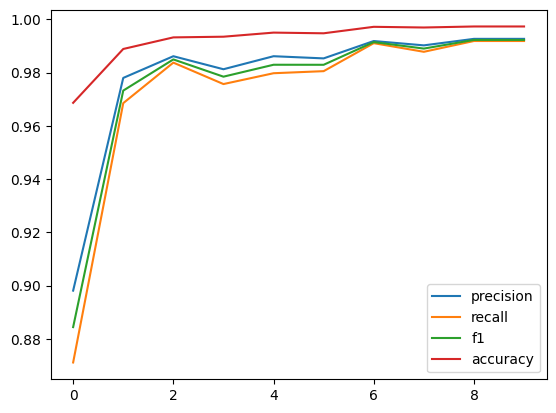

In [25]:
print(path_to_model)

metrics_df = pd.DataFrame(metrics_df)

print(metrics_df)
metrics_df.iloc[:, 1:].plot();

metrics_df.to_csv("metrics_"+path_to_model.replace("/", "-")+".csv")

ai-forever/ruBert-large
   epoch  precision    recall        f1  accuracy
0      1   0.953545  0.925633  0.939382  0.977479
1      2   0.947840  0.884411  0.915028  0.984142
2      3   0.977995  0.963082  0.970481  0.990005
3      4   0.969030  0.956557  0.962753  0.991471
4      5   0.987775  0.982172  0.984965  0.995336
5      6   0.991035  0.987815  0.989422  0.995602
6      7   0.991035  0.987815  0.989422  0.996402
7      8   0.991850  0.987024  0.989431  0.996269
8      9   0.991850  0.987024  0.989431  0.996269
9     10   0.991850  0.987024  0.989431  0.996269


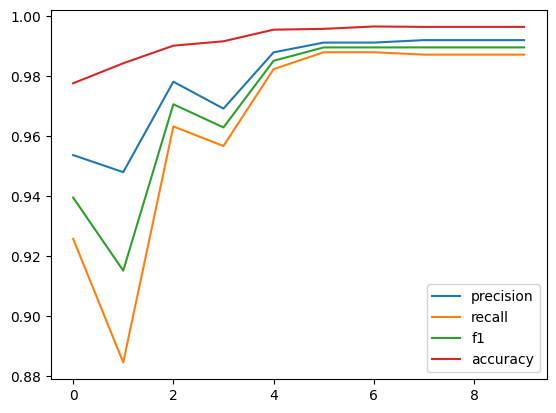

In [32]:
print(path_to_model)

metrics_df = pd.DataFrame(metrics_df)

print(metrics_df)
metrics_df.iloc[:, 1:].plot();

metrics_df.to_csv("metrics_"+path_to_model.replace("/", "-")+".csv")

DeepPavlov/rubert-base-cased
   epoch  precision    recall        f1  accuracy
0      1   0.986960  0.983753  0.985354  0.992829
1      2   0.982070  0.974131  0.978084  0.993155
2      3   0.979625  0.972492  0.976045  0.991525
3      4   0.986960  0.984553  0.985755  0.994133
4      5   0.983700  0.977328  0.980504  0.991037
5      6   0.991035  0.984615  0.987815  0.994296
6      7   0.990220  0.985401  0.987805  0.994133
7      8   0.990220  0.985401  0.987805  0.994133
8      9   0.991850  0.987024  0.989431  0.994622
9     10   0.991850  0.987024  0.989431  0.994459


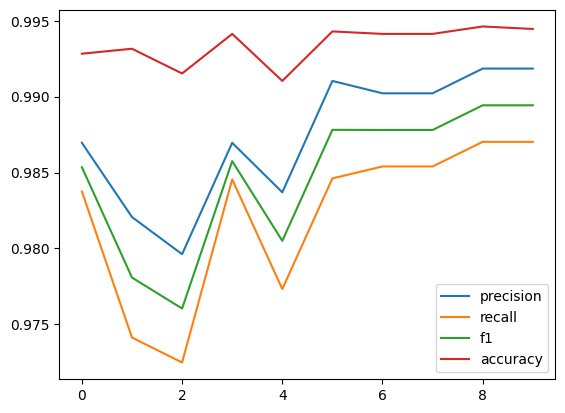

In [25]:
print(path_to_model)

metrics_df = pd.DataFrame(metrics_df)

print(metrics_df)
metrics_df.iloc[:, 1:].plot();

metrics_df.to_csv("metrics_"+path_to_model.replace("/", "-")+".csv")

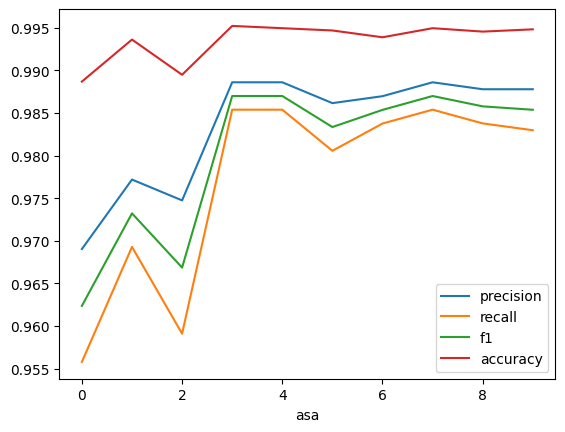

In [68]:
# print(path_to_model)

# metrics_df = pd.DataFrame(metrics_df)

# print(metrics_df)

metrics_df = pd.read_csv("results/adr/metrics_ai-forever-ruBert-base.csv")
metrics_df.iloc[:, 2:].plot()
plt.xlabel("Epoch");

# metrics_df.to_csv("metrics_"+path_to_model.replace("/", "-")+".csv")

Text(0.5, 1.0, 'Validation metrics for rubert-base-cased model')

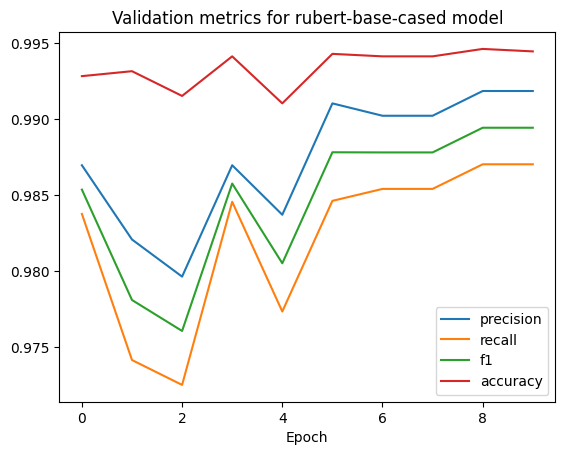

In [80]:
mod = "rubert-base-cased"
metrics_df = pd.read_csv("results/adr/metrics_DeepPavlov-" + mod + ".csv")
metrics_df.iloc[:, 2:].plot()
plt.xlabel("Epoch")
plt.title("Validation metrics for " + mod + " model")

Проверим, как хорошо работает наша модель.

In [26]:
# default
# path_to_model_NER_addresses = "model/stable/bert-finetuned-ner-addresses-accelerate-2/" 

# ruBert-base
# path_to_model_NER_addresses = "model/test/adr/bert-finetuned-ner-ai-forever-ruBert-base/" 

# ruBert-large
# path_to_model_NER_addresses = "model/test/adr/bert-finetuned-ner-ai-forever-ruBert-large/" 

# ruRoBerta-large
path_to_model_NER_addresses = "model/test/adr/bert-finetuned-ner-ai-forever-ruRoberta-large/" 

# deepPavlov cased ruBert-base
# path_to_model_NER_addresses = "model/test/adr/bert-finetuned-ner-DeepPavlov-rubert-base-cased/" 

In [27]:
## NER для адресов
label_names = ["O",
               "LOC-REG", 
               "LOC-DIST", 
               "LOC-SETL", 
               "LOC-CDIST", 
               "LOC-STRT", 
               "LOC-HOUS", 
               "LOC-FLAT"]

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

model_NER_adr = AutoModelForTokenClassification.from_pretrained(path_to_model_NER_addresses,
                                                               id2label=id2label,
                                                               label2id=label2id)

tokenizer_NER_adr = AutoTokenizer.from_pretrained(path_to_model_NER_addresses, use_fast=True)


In [28]:
test_dataloader = DataLoader(
    tokenized_datasets["test"], 
    collate_fn=data_collator, 
    batch_size=1
)

In [29]:
accelerator = Accelerator()

model_NER_adr, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
    model_NER_adr, optimizer, train_dataloader, test_dataloader
)

In [30]:
model_NER_adr.cpu()

token_classifier = pipeline(
    "token-classification", model=model_NER_adr, aggregation_strategy="simple", tokenizer=tokenizer_NER_adr
)

In [31]:
test_df = []

for i, batch in enumerate(test_dataloader):

    batch = batch.to("cpu")

    with torch.no_grad():
        outputs = model_NER_adr(**batch)

    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]

    # Necessary to pad predictions and labels for being gathered
    predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
    labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

    predictions_gathered = accelerator.gather(predictions)
    labels_gathered = accelerator.gather(labels)

    # print(predictions_gathered)
    # print(labels_gathered)

    true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered, label_names)

    # print(true_labels)
    # print(true_predictions)

    metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    test_df.append([
            results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        ]),
    
test_df = pd.DataFrame(test_df, columns = ["precision", "recall", "f1", "accuracy"])
print(test_df.mean(axis=0))
test_df.to_csv("test_df"+path_to_model.replace("/", "-")+".csv")

c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-CDIST seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-HOUS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-FLAT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LOC-STRT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\Artem Kondrashov\AppData\Local\Programs\Python\Python311\Lib\s

precision    0.991456
recall       0.989934
f1           0.990610
accuracy     0.996978
dtype: float64


In [30]:
token_classifier("Калужская обл., г. Обнинск, ул. Университетская, д.50")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[]

In [32]:
[print(i) for i in token_classifier(("Калужская обл., г. Обнинск, ул. Университетская, д.50").split(", "))]

[{'entity_group': 'REG', 'score': 0.9997234, 'word': 'Калужская обл.', 'start': 0, 'end': 14}]
[{'entity_group': 'SETL', 'score': 0.73663354, 'word': 'г', 'start': 0, 'end': 1}, {'entity_group': 'STRT', 'score': 0.41053164, 'word': '.', 'start': 1, 'end': 2}, {'entity_group': 'SETL', 'score': 0.95855904, 'word': 'Обнинск', 'start': 3, 'end': 10}]
[{'entity_group': 'STRT', 'score': 0.9989543, 'word': 'ул. Университетская', 'start': 0, 'end': 19}]
[{'entity_group': 'HOUS', 'score': 0.9997006, 'word': 'д. 50', 'start': 0, 'end': 4}]


[None, None, None, None]

In [33]:
[print(i) for i in token_classifier(("Проживала по адресу: Республика Башкортостан, г. Салават, б-р Космонавтов, д. 14, кв. 67"))]

{'entity_group': 'REG', 'score': 0.9971886, 'word': 'Республика Башкортостан,', 'start': 21, 'end': 45}
{'entity_group': 'SETL', 'score': 0.7373716, 'word': 'г', 'start': 46, 'end': 47}
{'entity_group': 'STRT', 'score': 0.38368496, 'word': '.', 'start': 47, 'end': 48}
{'entity_group': 'DIST', 'score': 0.8964835, 'word': 'Салават, б', 'start': 49, 'end': 59}
{'entity_group': 'STRT', 'score': 0.8866899, 'word': '- р Космонавтов,', 'start': 59, 'end': 74}
{'entity_group': 'HOUS', 'score': 0.9997664, 'word': 'д. 14', 'start': 75, 'end': 80}
{'entity_group': 'FLAT', 'score': 0.92317975, 'word': ', кв. 67', 'start': 80, 'end': 88}


[None, None, None, None, None, None, None]

In [34]:
[print(i) for i in token_classifier(("Проживала по адресу: Республика Башкортостан, г. Салават, б-р Космонавтов, д. 14, кв. 67").split(", "))]

[{'entity_group': 'REG', 'score': 0.9997072, 'word': 'Республика Башкортостан', 'start': 21, 'end': 44}]
[{'entity_group': 'STRT', 'score': 0.46289897, 'word': 'г.', 'start': 0, 'end': 2}, {'entity_group': 'CDIST', 'score': 0.75738543, 'word': 'Салават', 'start': 3, 'end': 10}]
[{'entity_group': 'STRT', 'score': 0.86801785, 'word': 'б - р Космонавтов', 'start': 0, 'end': 15}]
[{'entity_group': 'HOUS', 'score': 0.99971056, 'word': 'д. 14', 'start': 0, 'end': 5}]
[{'entity_group': 'FLAT', 'score': 0.99972516, 'word': 'кв. 67', 'start': 0, 'end': 6}]


[None, None, None, None, None]

In [35]:
[print(i) for i in token_classifier(("Башкирской АССР, г. Уфа, ул. Космонавтов, д. 1").split(", "))]

[{'entity_group': 'REG', 'score': 0.99976397, 'word': 'Башкирской АССР', 'start': 0, 'end': 15}]
[{'entity_group': 'STRT', 'score': 0.6688737, 'word': 'г. Уфа', 'start': 0, 'end': 6}]
[{'entity_group': 'STRT', 'score': 0.9988168, 'word': 'ул. Космонавтов', 'start': 0, 'end': 15}]
[{'entity_group': 'HOUS', 'score': 0.9997178, 'word': 'д. 1', 'start': 0, 'end': 4}]


[None, None, None, None]

In [36]:
[print(i) for i in \
 token_classifier(("Калужская обл., г. Обнинск, ул. Аксёнова, д. 33, кв.21, прибыла из г. Воскресенск Московской обл. в 1990 г").split(", "))]

[{'entity_group': 'REG', 'score': 0.9997234, 'word': 'Калужская обл.', 'start': 0, 'end': 14}]
[{'entity_group': 'SETL', 'score': 0.73663354, 'word': 'г', 'start': 0, 'end': 1}, {'entity_group': 'STRT', 'score': 0.41053164, 'word': '.', 'start': 1, 'end': 2}, {'entity_group': 'SETL', 'score': 0.95855904, 'word': 'Обнинск', 'start': 3, 'end': 10}]
[{'entity_group': 'STRT', 'score': 0.9985538, 'word': 'ул. Аксёнова', 'start': 0, 'end': 12}]
[{'entity_group': 'HOUS', 'score': 0.9996826, 'word': 'д. 33', 'start': 0, 'end': 5}]
[{'entity_group': 'FLAT', 'score': 0.99968165, 'word': 'кв. 21', 'start': 0, 'end': 5}]
[{'entity_group': 'SETL', 'score': 0.89095575, 'word': 'г. Воскресенск', 'start': 11, 'end': 25}, {'entity_group': 'REG', 'score': 0.9858875, 'word': 'Московской обл.', 'start': 26, 'end': 41}]


[None, None, None, None, None, None]

In [37]:
[print(i) for i in \
 token_classifier(("г. Москва, ул. Новочерёмушкинская, д. 27, кв. 154, прибыл из г. Обнинска Калужской обл. в 2020 г.").split(", "))]

[{'entity_group': 'STRT', 'score': 0.39412993, 'word': 'г.', 'start': 0, 'end': 2}, {'entity_group': 'REG', 'score': 0.88987494, 'word': 'Москва', 'start': 3, 'end': 9}]
[{'entity_group': 'STRT', 'score': 0.9979291, 'word': 'ул.', 'start': 0, 'end': 3}, {'entity_group': 'DIST', 'score': 0.74331725, 'word': 'Новочерёмушкин', 'start': 4, 'end': 18}, {'entity_group': 'STRT', 'score': 0.9628166, 'word': '##ская', 'start': 18, 'end': 22}]
[{'entity_group': 'HOUS', 'score': 0.99969226, 'word': 'д. 27', 'start': 0, 'end': 5}]
[{'entity_group': 'FLAT', 'score': 0.9997131, 'word': 'кв. 154', 'start': 0, 'end': 7}]
[{'entity_group': 'SETL', 'score': 0.986387, 'word': 'г. Обнинска', 'start': 10, 'end': 21}, {'entity_group': 'REG', 'score': 0.99979645, 'word': 'Калужской обл.', 'start': 22, 'end': 36}]


[None, None, None, None, None]

In [38]:
[print(i) for i in token_classifier(("г. Москва, ул. Новочерёмушкинская, д. 27, кв. 154, прибыл из г. Обнинска Калужской обл. в 2020 г."))]

{'entity_group': 'STRT', 'score': 0.38974646, 'word': '.', 'start': 1, 'end': 2}
{'entity_group': 'REG', 'score': 0.9085353, 'word': 'Москва', 'start': 3, 'end': 9}
{'entity_group': 'STRT', 'score': 0.7916319, 'word': ', ул. Новоч', 'start': 9, 'end': 20}
{'entity_group': 'DIST', 'score': 0.8571311, 'word': '##ерёму', 'start': 20, 'end': 25}
{'entity_group': 'STRT', 'score': 0.8755854, 'word': '##шкинская,', 'start': 25, 'end': 34}
{'entity_group': 'HOUS', 'score': 0.99972194, 'word': 'д. 27', 'start': 35, 'end': 40}
{'entity_group': 'FLAT', 'score': 0.9725791, 'word': ', кв. 154', 'start': 40, 'end': 49}
{'entity_group': 'SETL', 'score': 0.99088717, 'word': 'г. Обнинска', 'start': 61, 'end': 72}
{'entity_group': 'REG', 'score': 0.8296245, 'word': 'Калужской обл.', 'start': 73, 'end': 87}


[None, None, None, None, None, None, None, None, None]

In [39]:
def address_reconstruct(address: str) -> str:

    """
    Функция для исправления формата адреса в формат Регион, район, город/поселок, улица, дом, квартира 

    Параметры:
    address : str
        Строка, содержащая адрес

    Возвращает:
    string_out : str
        Строка с адресом требуемого формата
    """

    # создание словаря для сортировки элементов адреса
    entities = ["O", "REG", "DIST", "SETL", "CDIST", "STRT", "HOUS", "FLAT"]
    
    sort_dict = {key: elem for elem, key in list(enumerate(entities))}

    adr_tokens = address.strip().split(", ")

    # print(adr_tokens)

    NER_output = list(token_classifier(adr_tokens))

    addresses = [[]]
    adr_entities = [[]]
    i = 0

    for token, elem in zip(adr_tokens, NER_output):

        if len(elem) > 1:

            if elem[0]["start"] > 0:

                i += 1
                addresses.append([token[:elem[0]["start"]]])
                adr_entities.append(["O"])

            for subelem in elem:

                addresses[i].append(subelem["word"])
                adr_entities[i].append(subelem["entity_group"])

            if elem[-1]["end"] < len(token)-1:

                addresses[i].append(token[elem[-1]["end"]:])
                adr_entities[i].append("O")

        else:
            addresses[i].append(token)
            adr_entities[i].append(elem[0]["entity_group"])

    # print(addresses)
    # print(adr_entities)

    final_list = []

    for adr_lst, entity in zip(addresses, adr_entities):      

        # print("tokens:", adr_lst)
        # print("entities:", entity)    

        if entity[0] == "O":
                idx_start = 1
                left = adr_lst[0]
        else:
                idx_start = 0
                left = ""

        if entity[-1] == "O":
                idx_end = len(entity) - 1
                right = adr_lst[-1]
        else:
                idx_end = len(entity)
                right = ""

        adr_sorted = [x for _, x in sorted(zip(entity[idx_start:idx_end], adr_lst[idx_start:idx_end]), \
                                            key = lambda pair: sort_dict[pair[0]])]

        final_list.append(left + ", ".join(adr_sorted) + right)
        
        # print(final_list)

    # # переформирование адреса
    string_out = ", ".join(final_list)

    return(string_out)

In [40]:
adr_text = "ул. Новочерёмушкинская, д. 27, кв. 154, г. Москва, прибыл из г. Обнинска Калужской обл. в 2020 г."
address_reconstruct(adr_text)

'Москва, Новочерёмушкин, ул., ##ская, г., д. 27, кв. 154, прибыл из Калужской обл., г. Обнинска в 2020 г.'

In [41]:
adr_text = "г. Москва, Старокалужское ш., д. 62, корп. 4, стр. 1"
address_reconstruct(adr_text)

'Москва, Старокалужское ш., г., д. 62, стр. 1, корп. 4'

In [42]:
adr_text = "г. Москва, ул. Ярцевская, д. 29, корп.2, кв. 147"
address_reconstruct(adr_text)

'Москва, г., ул. Ярцевская, д. 29, корп.2, кв. 147'

In [43]:
address_reconstruct("ул. Университетская, д.50, г. Обнинск, Калужская обл.")

'Калужская обл., г, Обнинск, ул. Университетская, ., д.50'

In [44]:
address_reconstruct("ул. Ярцевская, д. 29, корп.2, кв. 147, г. Москва")

'Москва, ул. Ярцевская, г., д. 29, корп.2, кв. 147'

In [45]:
address_reconstruct("г. Хабаровск, Хабаровский край, Центральный р-н, ул. Гоголя, д. 42")

'г. Хабаровск, Хабаровский край, Центральный р-н, ул. Гоголя, д. 42'

В целом, качество распознавания элементов адреса очень неплохое, однако местами встречаются ошибки, вроде распознавание районов города как районов региона. В целом такие ошибки проблематично выловить по двум причинам - в наборе данных элементы адреса специально перемешаны, поскольку целью использования модели является восстановление порядка адреса - сначала регион, потом район, населенный пункт, район населенного пункта, улица, дом, квартира. Пользователь при вводе данных в форму может менять порядок некоторых элементов.

Решение - не использовать нейросеть, или же после получения вывода нейросети провести дополнительную обработку результата, однако подобное решение требует создания валидатора адреса, что в принципе убирает необходимость в нейросети.